In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

c:\Users\akshi\anaconda3\envs\gest\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\akshi\anaconda3\envs\gest\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\Users\akshi\anaconda3\envs\gest\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Keypoints using mediapipe

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connection

In [5]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5 ) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        
        #detection
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        #Draw landmarks
        draw_landmarks(image, results)
        
        cv2.imshow('Camera feed', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [6]:
draw_landmarks(frame, results)

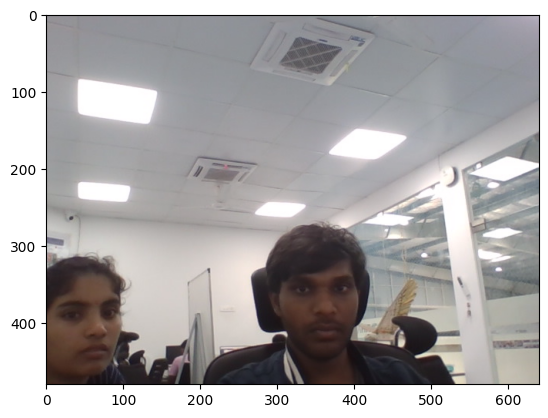

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
def exteact_keypoints(results):
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([rh])

## Data Collection

In [9]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['idle','takeoff', 'land', 'up', 'down', 'left', 'right', 'forward', 'backward'])
no_sequences = 30
sequence_length = 30

In [10]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass


In [11]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    for action in actions:

        for sequence in range(no_sequences):

            for frame_num in range(sequence_length):


                ret, frame = cap.read()


                image, results = mediapipe_detection(frame, holistic)
#                 print(results)


                draw_landmarks(image, results)
                

                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                keypoints = exteact_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

KeyboardInterrupt: 

In [12]:
cap.release()
cv2.destroyAllWindows()

## Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_map = {label:num for num, label in enumerate(actions)}

In [15]:
label_map

{'idle': 0,
 'takeoff': 1,
 'land': 2,
 'up': 3,
 'down': 4,
 'left': 5,
 'right': 6,
 'forward': 7,
 'backward': 8}

In [16]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [17]:
np.array(sequences).shape

(270, 30, 63)

In [18]:
np.array(labels).shape

(270,)

In [19]:
X = np.array(sequences)
X.shape

(270, 30, 63)

In [20]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [21]:
y.shape

(270, 9)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [26]:
y_test.shape

(14, 9)

## LSTM Neural Network

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [37]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [33]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 63)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [30]:
res = [0.7, 0.2, 0.1, 0.6, 0.3]
actions[np.argmax(res)]

'idle'

In [34]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 64)            32768     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 297       
Total params: 187,529
Trainable params: 187,529
Non-trainable params: 0
________________________________________________

In [38]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
8/8 [==============================] - 2s 51ms/step - loss: 2.1844 - categorical_accuracy: 0.1704
Epoch 2/1000
8/8 [==============================] - 0s 21ms/step - loss: 2.1197 - categorical_accuracy: 0.2318
Epoch 3/1000
8/8 [==============================] - 0s 21ms/step - loss: 2.1051 - categorical_accuracy: 0.2709
Epoch 4/1000
8/8 [==============================] - 0s 21ms/step - loss: 2.1208 - categorical_accuracy: 0.2400
Epoch 5/1000
8/8 [==============================] - 0s 23ms/step - loss: 2.0638 - categorical_accuracy: 0.2290
Epoch 6/1000
8/8 [==============================] - 0s 24ms/step - loss: 1.9899 - categorical_accuracy: 0.2321
Epoch 7/1000
8/8 [==============================] - 0s 21ms/step - loss: 1.8563 - categorical_accuracy: 0.3388
Epoch 8/1000
8/8 [==============================] - 0s 21ms/step - loss: 2.0573 - categorical_accuracy: 0.4090
Epoch 9/1000
8/8 [==============================] - 0s 21ms/step - loss: 1.5437 - categorical_accuracy: 0.4316
E

## Predictions

In [39]:
res = model.predict(X_test)

In [40]:
actions[np.argmax(res[1])]

'down'

In [41]:
actions[np.argmax(y_test[1])]

'land'

In [62]:
model.save('action.h5')

In [64]:
model.load_weights('action.h5')

## Model Evaluation

In [42]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [43]:
yhat = model.predict(X_test)

In [44]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [45]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[12,  0],
        [ 0,  2]],

       [[10,  2],
        [ 0,  2]],

       [[11,  0],
        [ 2,  1]],

       [[13,  0],
        [ 0,  1]],

       [[11,  1],
        [ 0,  2]],

       [[13,  0],
        [ 0,  1]],

       [[12,  0],
        [ 1,  1]],

       [[13,  0],
        [ 0,  1]]], dtype=int64)

In [46]:
accuracy_score(ytrue, yhat)

0.7857142857142857

## Real Time Predictions

In [47]:
# 1. New detection variables
sequence = []
sentence = []

threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = exteact_keypoints(results)
        sequence.insert(0,keypoints)
        sequence = sequence[:30]
        # sequence.append(keypoints)
        # sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti